In [10]:
import sys
import time

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# --- GLOBAL SEED & SETUP ---
# This ensures 100% reproducibility.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

models_dir = Path("models")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Global Seed: {SEED}")

Running on: cpu
Global Seed: 42


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0, init_std: float = 0.01):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T
        self.init_std = init_std
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)
        linear_v = v_W + c_mod
        term2_v = F.softplus(linear_v).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        fe_v = term1_v - term2_v
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)
        fe_flipped = term1_f - term2_f
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, steps: int, rng: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.view(-1, 1)
        cond = cond.to(self.W.device, dtype=self.W.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        B = cond.shape[0]
        # Annealing
        temps = torch.linspace(1.0, 1.0, steps, device=cond.device)
        v = (torch.rand((B, self.num_visible), generator=rng, device=cond.device) < 0.5).float()
        for i in range(steps):
            v = self._gibbs_step(v, b_mod, c_mod, float(temps[i]), rng)
        return v

In [3]:
def compute_renyi_large_batch(samples: torch.Tensor, subs_size: int,
                              log_score_fn: callable, chunk_size: int = 10_000) -> tuple:
    """
    Computes S2 on a massive batch by processing in chunks (to save GPU memory).
    Returns (Mean_S2, Standard_Error).
    """
    n_total = samples.shape[0]
    n_chunks = n_total // chunk_size

    # Pre-compute scores to save time
    scores = log_score_fn(samples)

    chunk_s2_values = []

    for i in range(n_chunks):
        # 1. Slice Chunk
        start = i * chunk_size
        end = (i + 1) * chunk_size
        c_samples = samples[start:end]
        c_scores = scores[start:end]

        half = chunk_size // 2

        # 2. Swap Test
        ref_1_score = c_scores[:half]
        ref_2_score = c_scores[half:]

        ref_1 = c_samples[:half]
        ref_2 = c_samples[half:]

        slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)
        swap_1 = ref_1.clone()
        swap_1[:, slice_idx] = ref_2[:, slice_idx]
        swap_2 = ref_2.clone()
        swap_2[:, slice_idx] = ref_1[:, slice_idx]

        swap_1_score = log_score_fn(swap_1)
        swap_2_score = log_score_fn(swap_2)

        # 3. Log Ratio
        log_ratios = (swap_1_score + swap_2_score) - (ref_1_score + ref_2_score)

        # 4. LogSumExp for Stability
        max_val = torch.max(log_ratios)
        log_sum_exp = torch.log(torch.sum(torch.exp(log_ratios - max_val))) + max_val
        log_mean = log_sum_exp - math.log(half)

        chunk_s2_values.append(-log_mean.item())

    # Aggregate results from chunks
    vals = np.array(chunk_s2_values)
    mean = np.mean(vals)
    err = np.std(vals, ddof=1) / np.sqrt(n_chunks)

    return mean, err

def load_checkpoint(filename):
    path = Path(filename)
    if not path.exists(): path = models_dir / filename
    print(f"Loading: {path}")
    checkpoint = torch.load(path, map_location=device)
    cfg = checkpoint.get("config", {})
    if "system_size" not in cfg: cfg["system_size"] = 16

    model = ConditionalRBM(
        num_visible=cfg["system_size"],
        num_hidden=cfg.get("num_hidden", 112),
        cond_dim=cfg.get("cond_dim", 1),
        conditioner_width=cfg.get("cond_width", 64),
        k=cfg.get("cd_k", 15),
        init_std=cfg.get("init_std", 0.01)
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint)
    model.eval()
    return model, cfg

In [6]:
# --- UPDATE FILENAME HERE ---
filename = "crbm_tfim_16_10000_20251211_235756.pt"

model, config = load_checkpoint(filename)

CHAIN_LENGTH = config["system_size"]
h_support_vals = sorted(config["h_support"])

print(f"Model Loaded. System Size: {CHAIN_LENGTH}")
print(f"Support Points: {h_support_vals}")

Loading: models/crbm_tfim_16_10000_20251211_235756.pt
Model Loaded. System Size: 16
Support Points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]


In [7]:
# Dense Grid Setup
dense_resolution = 0.05
h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, dense_resolution)
h_novel_vals = np.array([h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)])
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

# === BRUTE FORCE SETTINGS ===
# Exact settings from original script for smoothing l=6 bump
TOTAL_SAMPLES = 300_000
CHUNK_SIZE = 10_000
EVAL_STEPS = 200

results_list = []
l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))
rng_eval = torch.Generator(device=device).manual_seed(SEED) # Explicit seed usage
model_dtype = next(model.parameters()).dtype

print(f"=== GENERATING ENTROPY DATA ===")
print(f"Strategy: {TOTAL_SAMPLES} samples per point (Brute Force Smoothing).")
print(f"Evaluating {len(all_h_values)} values of h...")

for i, h_val in enumerate(all_h_values):
    pt_type = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"

    cond_gen = torch.tensor([[h_val]], device=device, dtype=model_dtype).expand(TOTAL_SAMPLES, -1)

    with torch.no_grad():
        samples = model.generate(cond_gen, EVAL_STEPS, rng_eval)

    # symmetrize .... this is an early hack i did instead of exact 3-block gibbs sampling
    flip_mask = (torch.rand(samples.shape[0], 1, device=device) < 0.5).float()
    samples = samples * (1 - flip_mask) + (1 - samples) * flip_mask

    cond_score = torch.tensor([[h_val]], device=device, dtype=model_dtype)
    scorer = lambda v: model.log_score(v, cond_score)

    for l in l_axis:
        # We chunk for memory, but treat it as one big batch stats-wise
        s2_mean, s2_err = compute_renyi_large_batch(samples, l, scorer, chunk_size=CHUNK_SIZE)

        results_list.append({
            "h": float(h_val), "l": int(l), "s2": s2_mean, "s2_err": s2_err, "type": pt_type
        })

    if (i+1) % 5 == 0:
        print(f"[{i+1}/{len(all_h_values)}] h={h_val:.2f}")

df_res = pd.DataFrame(results_list)
print("Data generation done.")

=== GENERATING ENTROPY DATA ===
Strategy: 300000 samples per point (Brute Force Smoothing).
Evaluating 21 values of h...
[5/21] h=0.70
[10/21] h=0.95
[15/21] h=1.20
[20/21] h=1.45
Data generation done.


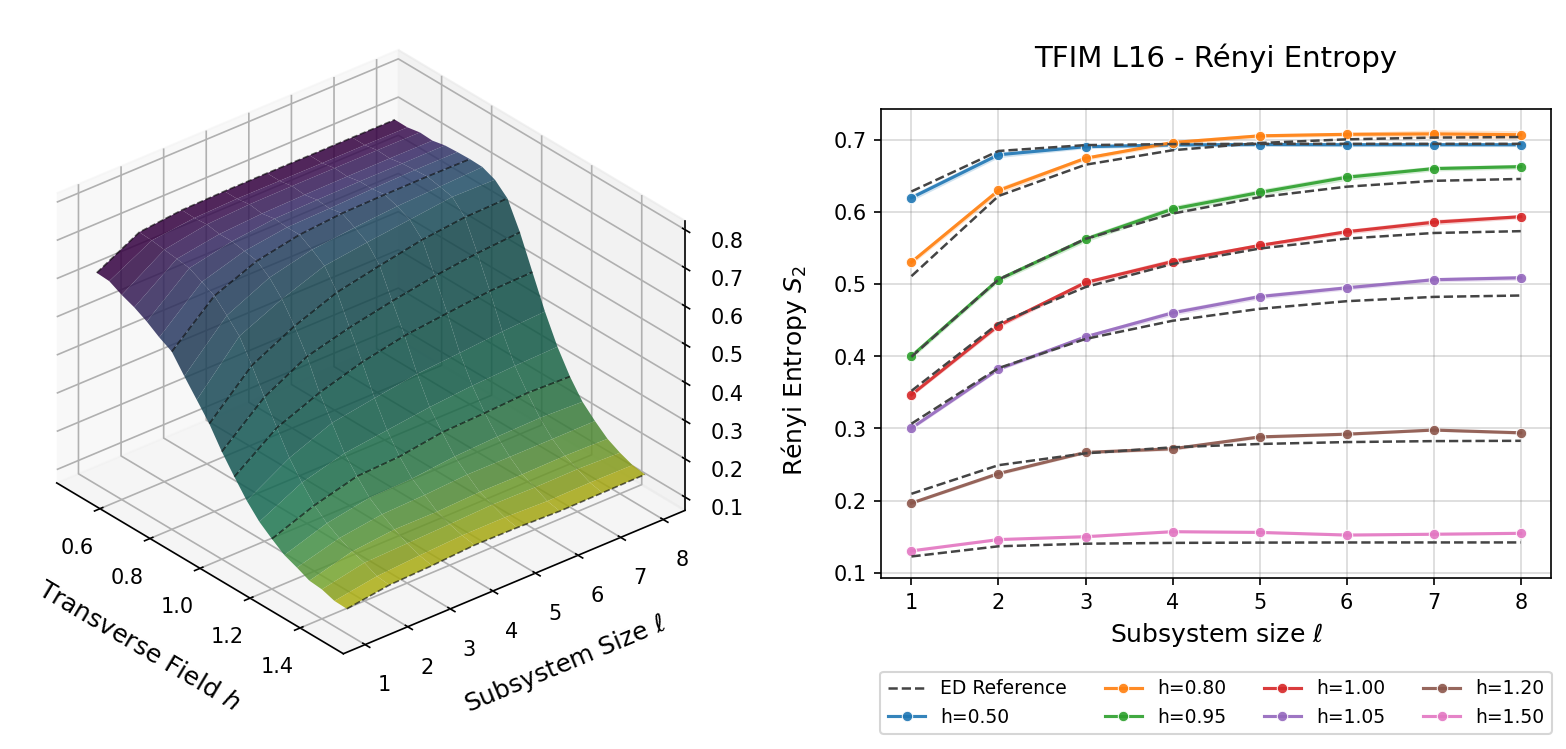

In [9]:
# CONFIGURATION
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

# Process Data
pivot_df = df_res.pivot(index='l', columns='h', values='s2')
h_dense = pivot_df.columns.values
l_values = pivot_df.index.values
X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.values

support_h_keys = df_res[df_res['type'] == 'support']['h'].unique()
support_h_keys.sort()

# Plot
fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# 3D
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho')
cmap_surface = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())
surface_colors = cmap_surface(norm(X_h))
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor=None, linewidth=0, alpha=0.85, antialiased=True)
ax3d.set_zlim(np.min(Z_s2)-0.05, np.max(Z_s2)+0.1)
ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

# 2D
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
new_pos = [pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height]
ax2d.set_position(new_pos)
cmap_2d_cycle = plt.get_cmap("tab10")

# Optional: Load reference file if exists
try:
    ref_file = Path(f"tfim_{CHAIN_LENGTH}_entropy_ref.csv")
    ref_df = pd.read_csv(ref_file) if ref_file.exists() else None
except: ref_df = None
ref_label_added = False

for i, h in enumerate(support_h_keys):
    subset = df_res[df_res['h'] == h].sort_values('l')
    s2_vals = subset['s2'].values
    err_vals = subset['s2_err'].values

    line_color = cmap_2d_cycle(i % 10)
    xs_3d = np.full_like(l_values, h, dtype=float)
    ax3d.plot(xs_3d, l_values, s2_vals, color='black', linestyle='--', linewidth=0.8, alpha=0.6, zorder=10)

    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-3)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values], key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            x_ref = [int(c[1:]) for c in l_cols]
            lbl = "ED Reference" if not ref_label_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, linestyle='--', color='#444444', linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-', color=line_color, markersize=5, linewidth=1.5, alpha=0.9, markeredgecolor='white', markeredgewidth=0.5, label=f"h={h:.2f}", zorder=4)
    # Shaded error region (faint)
    ax2d.fill_between(l_values, s2_vals - err_vals, s2_vals + err_vals, color=line_color, alpha=0.2, linewidth=0)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")
ax2d.set_title("TFIM L16 - Rényi Entropy", fontsize=14, pad=TITLE_PAD_2D)
ax2d.legend(frameon=True, fontsize=9, loc='upper center', bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3, color='gray')
plt.show()

In [11]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
save_path = Path(f"tfim_l{CHAIN_LENGTH}_entangle_rbm_{timestamp}.csv")

df_res.to_csv(save_path, index=False)

print(f"Results saved successfully to: {save_path}")
print(f"Rows: {len(df_res)}")

Results saved successfully to: tfim_l16_entangle_rbm_20251212_030007.csv
Rows: 168
